Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q torch
!pip install -q watermark
!pip install -q matplotlib
!pip install -q tensorwatch
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz

     |████████████████████████████████| 194kB 8.3MB/s 
     |████████████████████████████████| 143kB 17.7MB/s 


In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


- Runs on CPU or GPU (if available)

# Model Zoo -- Convolutional Neural Network with He Initialization

## Imports

In [3]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Model

In [5]:
##########################
### MODEL
##########################


class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0
        
        self.linear_1 = torch.nn.Linear(7*7*8, num_classes)
        
        ###############################################
        # Reinitialize weights using He initialization
        ###############################################
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        logits = self.linear_1(out.view(-1, 7*7*8))
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

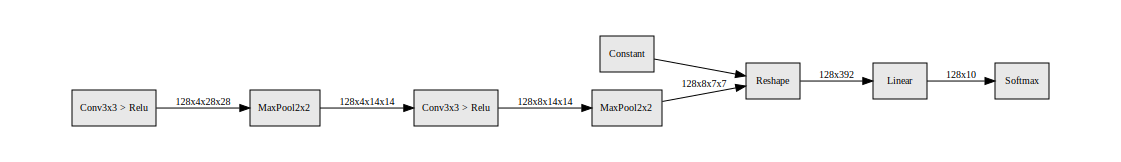

In [6]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([128, 1, 28, 28]).to(device))

## Training

In [7]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    model = model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))
    
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 2.4577
Epoch: 001/010 | Batch 050/469 | Cost: 1.1068
Epoch: 001/010 | Batch 100/469 | Cost: 0.6610
Epoch: 001/010 | Batch 150/469 | Cost: 0.5354
Epoch: 001/010 | Batch 200/469 | Cost: 0.4479
Epoch: 001/010 | Batch 250/469 | Cost: 0.3159
Epoch: 001/010 | Batch 300/469 | Cost: 0.4545
Epoch: 001/010 | Batch 350/469 | Cost: 0.4277
Epoch: 001/010 | Batch 400/469 | Cost: 0.1386
Epoch: 001/010 | Batch 450/469 | Cost: 0.1410
Epoch: 001/010 training accuracy: 91.96%
Time elapsed: 0.34 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.2198
Epoch: 002/010 | Batch 050/469 | Cost: 0.1464
Epoch: 002/010 | Batch 100/469 | Cost: 0.2627
Epoch: 002/010 | Batch 150/469 | Cost: 0.1919
Epoch: 002/010 | Batch 200/469 | Cost: 0.1486
Epoch: 002/010 | Batch 250/469 | Cost: 0.1228
Epoch: 002/010 | Batch 300/469 | Cost: 0.1591
Epoch: 002/010 | Batch 350/469 | Cost: 0.1410
Epoch: 002/010 | Batch 400/469 | Cost: 0.1405
Epoch: 002/010 | Batch 450/469 | Cost: 0.1210
Epoch: 002/010 t

## Evaluation

In [8]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 97.65%


In [9]:
%watermark -iv

numpy 1.18.5
torch 1.5.1+cu101

